In [1]:
"""
Code for reproducing figures in the paper.
This notebook contains all visualization code for the main figures and supplementary figures.
"""

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
import pycountry
import plotly.express as px
import plotly.io as pio
from scipy.stats import spearmanr

# Figure  and Figure S2

In [3]:
# Load main dataset
df = pd.read_csv('aiwriting_data.csv')

# Preprocess date columns
df['accepted_date'] = pd.to_datetime(df['accepted_date'])
df['accepted_year'] = df['accepted_date'].dt.year

In [4]:
# Helper Functions for Country Analysis

In [5]:
def analyze_author_countries(df, author_order='first'):
    """
    Analyze author countries by publication year and filter those with sufficient sample size.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        author_order (str): Which author position to consider ('first' or 'corresponding').
        
    Returns:
        valid_countries (list): List of country names meeting the threshold.
        country_stats (dict): Per-country statistics by year.
    """
    if author_order not in ['first', 'corresponding']:
        raise ValueError("author_order must be 'first' or 'corresponding'")
    
    country_col = f'{author_order}_author_country'
    
    # Drop rows with missing country and those with multiple countries
    df_clean = df.dropna(subset=[country_col])
    df_clean = df_clean[~df_clean[country_col].astype(str).str.contains(',')]
    
    country_stats = {}
    
    # Iterate through rows, update statistics per country
    for _, row in df_clean.iterrows():
        country_str = row[country_col]
        accepted_year = row['accepted_year']
        
        if pd.notna(country_str):
            countries = [c.strip() for c in str(country_str).split(',') if c.strip()]
            for country in countries:
                if country not in country_stats:
                    country_stats[country] = {
                        'pre_gpt': 0,
                        'post_gpt': 0,
                        'total': 0,
                        'yearly_counts': {2021: 0, 2022: 0, 2023: 0, 2024: 0}
                    }
                country_stats[country]['total'] += 1
                if accepted_year in [2021, 2022, 2023, 2024]:
                    country_stats[country]['yearly_counts'][accepted_year] += 1
    
    print(f"Found {len(country_stats)} unique author countries.")
    valid_countries = []
    
    # Filter valid countries by requiring >=100 samples per each year
    for country, stats in country_stats.items():
        yearly_counts = stats['yearly_counts']
        if all(yearly_counts[year] >= 100 for year in [2021, 2022, 2023, 2024]):
            valid_countries.append(country)
    
    print(f"Valid author countries meeting sample threshold ({len(valid_countries)}):")
    return valid_countries, country_stats

def prepare_country_data(df, author_order='first'):
    """
    Add dummy variables to the dataframe for each valid author country.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        author_order (str): 'first' or 'corresponding'.
        
    Returns:
        valid_countries (list): List of country names.
        df (pd.DataFrame): DataFrame with indicator variables for each country.
    """
    valid_countries, country_stats = analyze_author_countries(df, author_order=author_order)
    if len(valid_countries) == 0:
        raise ValueError("No author countries meet the sample size requirement.")
    country_col = f'{author_order}_author_country'
    # Create a dummy variable (0/1) for each valid country
    for country in valid_countries:
        var_name = f'author_country_{country}'
        df[var_name] = df[country_col].fillna('').str.contains(country, na=False).astype(int)
    return valid_countries, df

In [6]:
# Prepare country data for first and corresponding authors
valid_countries_first, df_first = prepare_country_data(df.copy(), author_order='first')
valid_countries_corresponding, df_corresponding = prepare_country_data(df.copy(), author_order='corresponding')

Found 215 unique author countries.
Valid author countries meeting sample threshold (90):
Found 218 unique author countries.
Valid author countries meeting sample threshold (87):


In [7]:
# Calculate country-level changes in AI content fraction
country_results = []

# Use union of both country sets so both columns always align
all_countries = sorted(set(valid_countries_first).union(set(valid_countries_corresponding)))

for country in all_countries:
    if country in valid_countries_first:
        temp1_first = df_first[(df_first['accepted_year'] > 2022) & (df_first[f'author_country_{country}'] == 1)]
        temp2_first = df_first[(df_first['accepted_year'] <= 2022) & (df_first[f'author_country_{country}'] == 1)]
        count_first = df_first[df_first[f'author_country_{country}'] == 1].shape[0]
        first_change = temp1_first['AI_content_fraction'].mean() - temp2_first['AI_content_fraction'].mean()
    else:
        first_change = None
        count_first = 0

    if country in valid_countries_corresponding:
        temp1_corr = df_corresponding[(df_corresponding['accepted_year'] > 2022) & (df_corresponding[f'author_country_{country}'] == 1)]
        temp2_corr = df_corresponding[(df_corresponding['accepted_year'] <= 2022) & (df_corresponding[f'author_country_{country}'] == 1)]
        count_corr = df_corresponding[df_corresponding[f'author_country_{country}'] == 1].shape[0]
        corresponding_change = temp1_corr['AI_content_fraction'].mean() - temp2_corr['AI_content_fraction'].mean()
    else:
        corresponding_change = None
        count_corr = 0

    country_results.append([
        country,
        first_change, count_first,
        corresponding_change, count_corr
    ])

df_country = pd.DataFrame(
    country_results, 
    columns=[
        'country', 'first_change', 'first_count', 'corresponding_change', 'corresponding_count'
    ]
)

In [8]:
# Merge with country-level English Proficiency Index and language type data
country_epi = pd.read_csv('country_epi.txt', sep='\t')
country_type = pd.read_csv('country_language_type.txt', sep='\t')

print('Number of valid countries:', df_country.shape[0])
country_increase_epi = pd.merge(country_epi, df_country, on='country')
print('Countries with epidemiological score:', country_increase_epi.shape[0])
country_increase_epi = pd.merge(country_increase_epi, country_type, on='country')
print('Countries classified by language type:', country_increase_epi.shape[0])

# Compute Spearman correlation between AI content change and English Proficiency Index
mask_first = country_increase_epi[['first_change', 'score']].notnull().all(axis=1)
spearman_corr, spearman_p = spearmanr(
    country_increase_epi.loc[mask_first, 'first_change'],
    country_increase_epi.loc[mask_first, 'score']
)
print(f'First author: Spearman correlation = {spearman_corr:.4f}, p-value = {spearman_p:.4g}')

mask_corr = country_increase_epi[['corresponding_change', 'score']].notnull().all(axis=1)
spearman_corr, spearman_p = spearmanr(
    country_increase_epi.loc[mask_corr, 'corresponding_change'],
    country_increase_epi.loc[mask_corr, 'score']
)
print(f'Corresponding author: Spearman correlation = {spearman_corr:.4f}, p-value = {spearman_p:.4g}')

Number of valid countries: 90
Countries with epidemiological score: 78
Countries classified by language type: 66
First author: Spearman correlation = -0.6532, p-value = 2.779e-09
Corresponding author: Spearman correlation = -0.6231, p-value = 3.825e-08


In [9]:
# Convert country codes from ISO-2 to ISO-3 for map visualization
def iso2_to_iso3(iso2):
    try:
        return pycountry.countries.get(alpha_2=iso2).alpha_3
    except:
        return None

df_country['country_iso3'] = df_country['country'].apply(iso2_to_iso3)


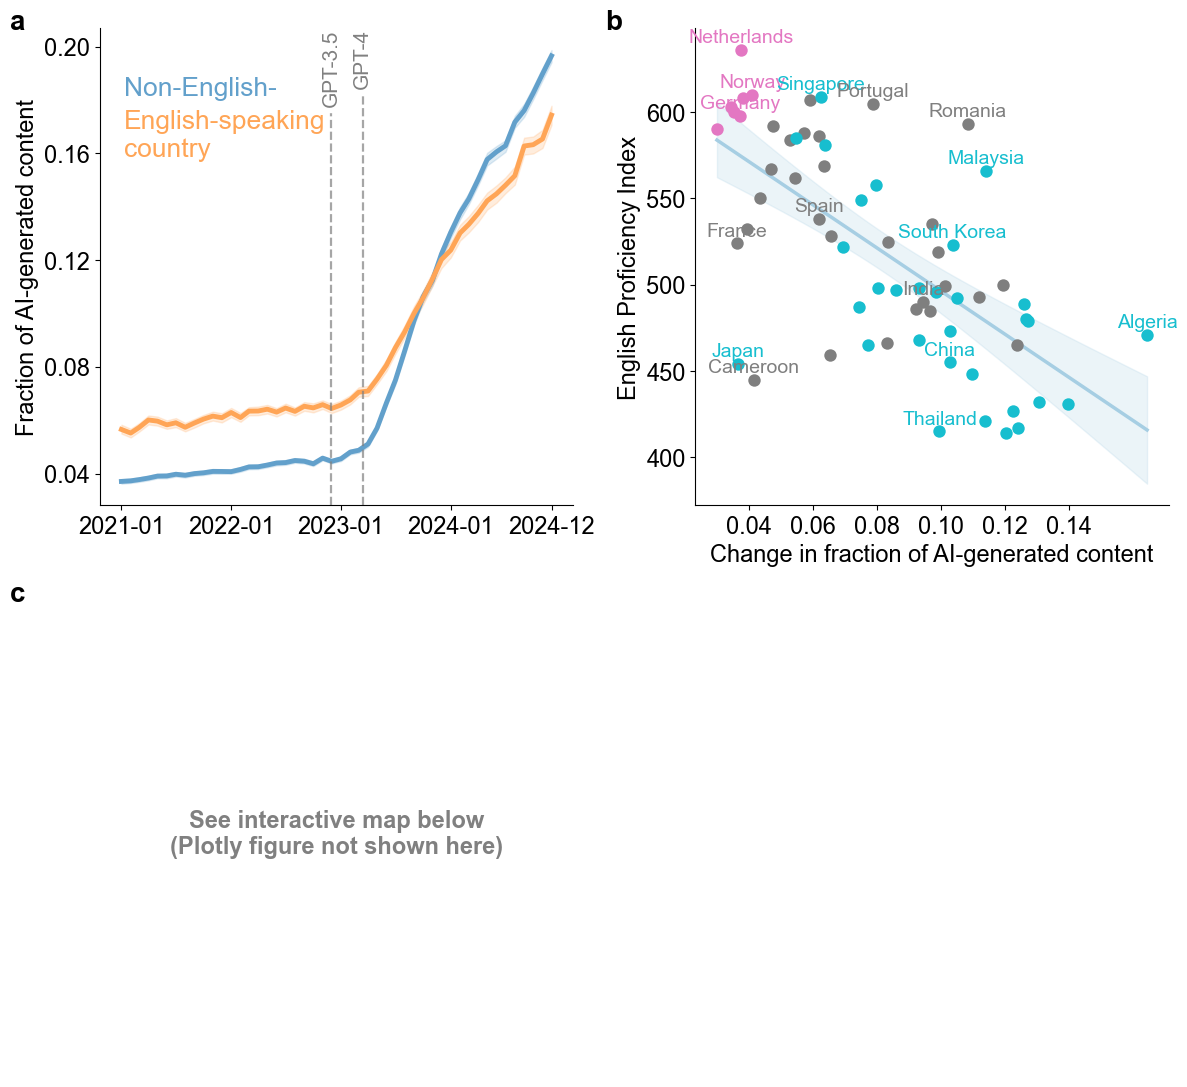

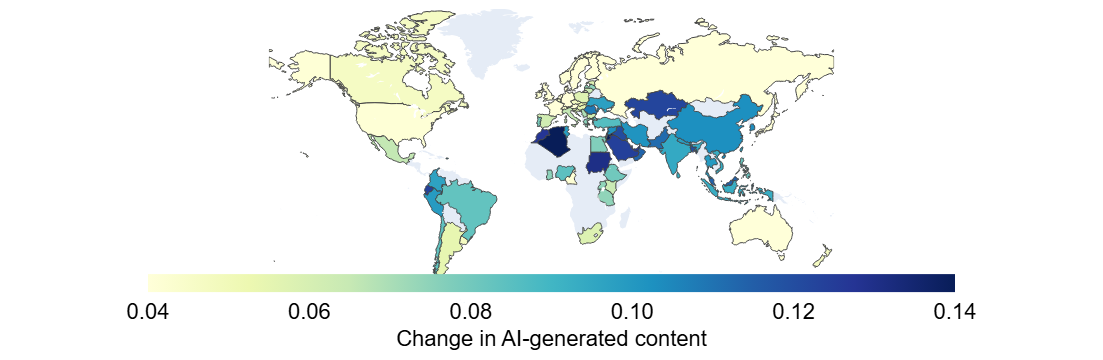

In [11]:
# Figure 1: First Author Analysis
# Define color constants
COLOR_ENGLISH = "#62a0cb"
COLOR_NON_ENGLISH = "#ffa556"
COLOR_SCATTER_GERMANIC = "#e377c2"
COLOR_SCATTER_INDOEU = "#7f7f7f"
COLOR_SCATTER_NON_INDOEU = "#17becf"
SCATTER_TYPE_COLOR_MAP = {
    "Germanic (excl. English)": COLOR_SCATTER_GERMANIC,
    "Other Indo-European": COLOR_SCATTER_INDOEU,
    "Non Indo-European": COLOR_SCATTER_NON_INDOEU
}
COLOR_SCATTER_REG_LINE = '#a6cee3'
COLOR_SCATTER_REG_BAND = '#a6cee3'
COLOR_SCATTER_REG_BAND_ALPHA = 0.22

COLOR_MAP_CONTINUOUS = 'YlGnBu'
COLOR_LABEL_TEXT = 'black'
COLOR_MAP_PLACEHOLDER = 'gray'

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

fig, axes = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={'height_ratios': [1, 1]})

# Line plot (panel a)
ax1 = axes[0, 0]
custom_line_colors = [COLOR_ENGLISH, COLOR_NON_ENGLISH]
sns.lineplot(
    data=df,
    x='accepted_date',
    y='AI_content_fraction',
    hue='first_author_english_speaking_country',
    palette=custom_line_colors,
    ax=ax1,
    linewidth=3.5,
    alpha=1
)
lines = ax1.get_lines()
label_map = {
    '1.0': "English-speaking\ncountry",
    '0.0': "Non-English-\nspeaking country"
}
hue_order = sorted(df['first_author_english_speaking_country'].dropna().unique())
x0, x1 = ax1.get_xlim()
y0, y1 = ax1.get_ylim()
text_x = x0 + (x1 - x0) * 0.05
text_y = y1 - (y1 - y0) * 0.1
line_gap = (y1 - y0) * 0.07
legend_fontsize = 17
for i, val in enumerate(hue_order):
    color = custom_line_colors[i] if i < len(custom_line_colors) else lines[i].get_color()
    label = label_map.get(str(val), str(val))
    ax1.text(
        text_x,
        text_y - i * line_gap,
        label,
        color=color,
        fontsize=legend_fontsize + 2,
        fontname='Arial',
        ha='left', va='top',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=1)
    )

ax1.set_ylabel('Fraction of AI-generated content', fontname='Arial', fontsize=legend_fontsize)
date_range = pd.to_datetime(['2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01', '2024-12-01'])
ax1.set_xticks(date_range)
ax1.set_xticklabels([d.strftime('%Y-%m') for d in date_range], fontname='Arial', fontsize=legend_fontsize)
ax1.set_xlabel(None)
ax1.tick_params(axis='both', labelsize=legend_fontsize, colors=COLOR_LABEL_TEXT)
if ax1.legend_ is not None:
    ax1.legend_.remove()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
yticks_custom = [0.04, 0.08, 0.12, 0.16, 0.20]
ax1.set_yticks(yticks_custom)
ax1.set_yticklabels([f"{y:.2f}" for y in yticks_custom], fontname='Arial', fontsize=legend_fontsize)
ax1.text(-0.19, 1.04, 'a', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# Add vertical lines and annotations for GPT releases
gpt35_date = pd.to_datetime('2022-11-30')
gpt4_date = pd.to_datetime('2023-03-14')
for date, label in zip([gpt35_date, gpt4_date], ['GPT-3.5', 'GPT-4']):
    ax1.axvline(date, color='gray', linestyle='--', linewidth=1.6, alpha=0.7, zorder=5)
    ax1.text(
        date, ax1.get_ylim()[1],
        label,
        color='gray',
        fontsize=legend_fontsize - 2,
        fontname='Arial',
        rotation=90,
        va='top',
        ha='center',
        backgroundcolor='white',
        zorder=6,
        clip_on=False
    )

# Scatter plot with regression (panel b)
type_order = [
    "Germanic (excl. English)",
    "Other Indo-European",
    "Non Indo-European"
]
color_map = SCATTER_TYPE_COLOR_MAP

ax3 = axes[0, 1]
for t in type_order:
    data = country_increase_epi[country_increase_epi['language_family'] == t]
    ax3.scatter(
        data['first_change'], data['score'],
        color=color_map[t],
        s=80,
        alpha=1,
        linewidth=0,
        zorder=3,
        label=t
    )

scatter_df = country_increase_epi.dropna(subset=['first_change', 'score'])
X = scatter_df['first_change'].values
y = scatter_df['score'].values

# Fit OLS regression
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

x_range = np.linspace(X.min(), X.max(), 200)
X_pred = sm.add_constant(x_range)
y_pred = model.predict(X_pred)
pred = model.get_prediction(X_pred)
conf_int = pred.conf_int(alpha=0.05)
ci_lower = conf_int[:, 0]
ci_upper = conf_int[:, 1]

ax3.plot(x_range, y_pred, color=COLOR_SCATTER_REG_LINE, linewidth=2.5, zorder=2)
ax3.fill_between(x_range, ci_lower, ci_upper, color=COLOR_SCATTER_REG_BAND, alpha=COLOR_SCATTER_REG_BAND_ALPHA, zorder=1)

ax3.set_xlabel('Change in fraction of AI-generated content', fontdict={'family': 'Arial', 'size': 17, 'color': COLOR_LABEL_TEXT})
ax3.set_ylabel('English Proficiency Index', fontdict={'family': 'Arial', 'size': 17, 'color': COLOR_LABEL_TEXT})
ax3.tick_params(axis='both', labelsize=legend_fontsize, colors=COLOR_LABEL_TEXT)

xticks_custom = [0.04, 0.06, 0.08, 0.10, 0.12, 0.14]
ax3.set_xticks(xticks_custom)
ax3.set_xticklabels([f"{x:.2f}" for x in xticks_custom], fontname='Arial', fontsize=legend_fontsize)
ax3.spines['bottom'].set_color(COLOR_LABEL_TEXT)
ax3.spines['left'].set_color(COLOR_LABEL_TEXT)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.text(-0.19, 1.04, 'b', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# Annotate selected countries on scatter plot
country_code_to_name_map = {
    'SG': 'Singapore', 'CN': 'China', 'NL': 'Netherlands', 'IN': 'India',
    'FR': 'France', 'DE': 'Germany', 'JP': 'Japan', 'CM': 'Cameroon',
    'RO': 'Romania', 'KR': 'South Korea', 'PT': 'Portugal', 'ES': 'Spain',
    'NO': 'Norway', 'TH': 'Thailand', 'DZ': 'Algeria', 'MY': 'Malaysia'
}
special_countries = list(country_code_to_name_map.keys())
for idx, row in country_increase_epi[country_increase_epi['country'].isin(special_countries)].iterrows():
    country_type = row['language_family']
    this_color = color_map.get(country_type, COLOR_LABEL_TEXT)
    country_label = country_code_to_name_map.get(row['country'], row['country'])
    ax3.text(
        row['first_change'], row['score'] + 2, country_label,
        color=this_color, fontsize=legend_fontsize - 3, fontfamily='Arial',
        ha='center', va='bottom', zorder=15
    )

# Determine which column to use for ISO-3 codes
iso3_col = None
if 'country_iso3' in df_country.columns:
    iso3_col = 'country_iso3'
elif 'country' in df_country.columns and df_country['country'].apply(lambda c: isinstance(c, str) and len(c) == 3 and c.isalpha()).all():
    iso3_col = 'country'
else:
    raise ValueError("No valid ISO-3 code column found in df_country. Please ensure 'country_iso3' exists or 'country' is ISO-3.")

# Create choropleth map (panel c)
color_ticks = [0.04, 0.06, 0.08, 0.10, 0.12, 0.14]
color_min = min(color_ticks)
color_max = max(color_ticks)

fig_map = px.choropleth(
    data_frame=df_country,
    locations=iso3_col,
    locationmode='ISO-3',
    color='first_change',
    color_continuous_scale=COLOR_MAP_CONTINUOUS,
    projection='miller',
    labels={'first_change': 'Change in fraction of AI-generated content'},
    range_color=(color_min, color_max)
)
fig_map.update_geos(
    showframe=False,
    showcoastlines=False,
    lataxis_range=[-45, 90],
)
fig_map.update_layout(
    coloraxis_colorbar=dict(
        title=dict(
            text='Change in AI-generated content',
            side='bottom',
            font=dict(
                family='Arial',
                size=legend_fontsize + 5,
                color=COLOR_LABEL_TEXT
            )
        ),
        tickvals=color_ticks,
        ticktext=[f"{v:.2f}" for v in color_ticks],
        tickfont=dict(
            family='Arial',
            size=legend_fontsize + 5,
            color=COLOR_LABEL_TEXT
        ),
        thickness=18,
        orientation='h',
        x=0.5,
        xanchor='center',
        y=-0.19,  # Move colorbar further down
        yanchor='bottom',
        len=0.75
    ),
    margin=dict(l=0, r=0, t=0, b=0)
)

axes[1, 0].axis('off')
axes[1, 0].text(
    0.5, 0.51,
    "See interactive map below\n(Plotly figure not shown here)",
    ha='center', va='center', fontsize=legend_fontsize, fontweight='bold', color=COLOR_MAP_PLACEHOLDER, fontname='Arial',
    transform=axes[1, 0].transAxes
)
axes[1, 0].text(-0.19, 1.04, 'c', transform=axes[1, 0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

axes[1, 1].axis('off')

plt.tight_layout(h_pad=2)
plt.show()
pio.show(fig_map)

posx and posy should be finite values
posx and posy should be finite values


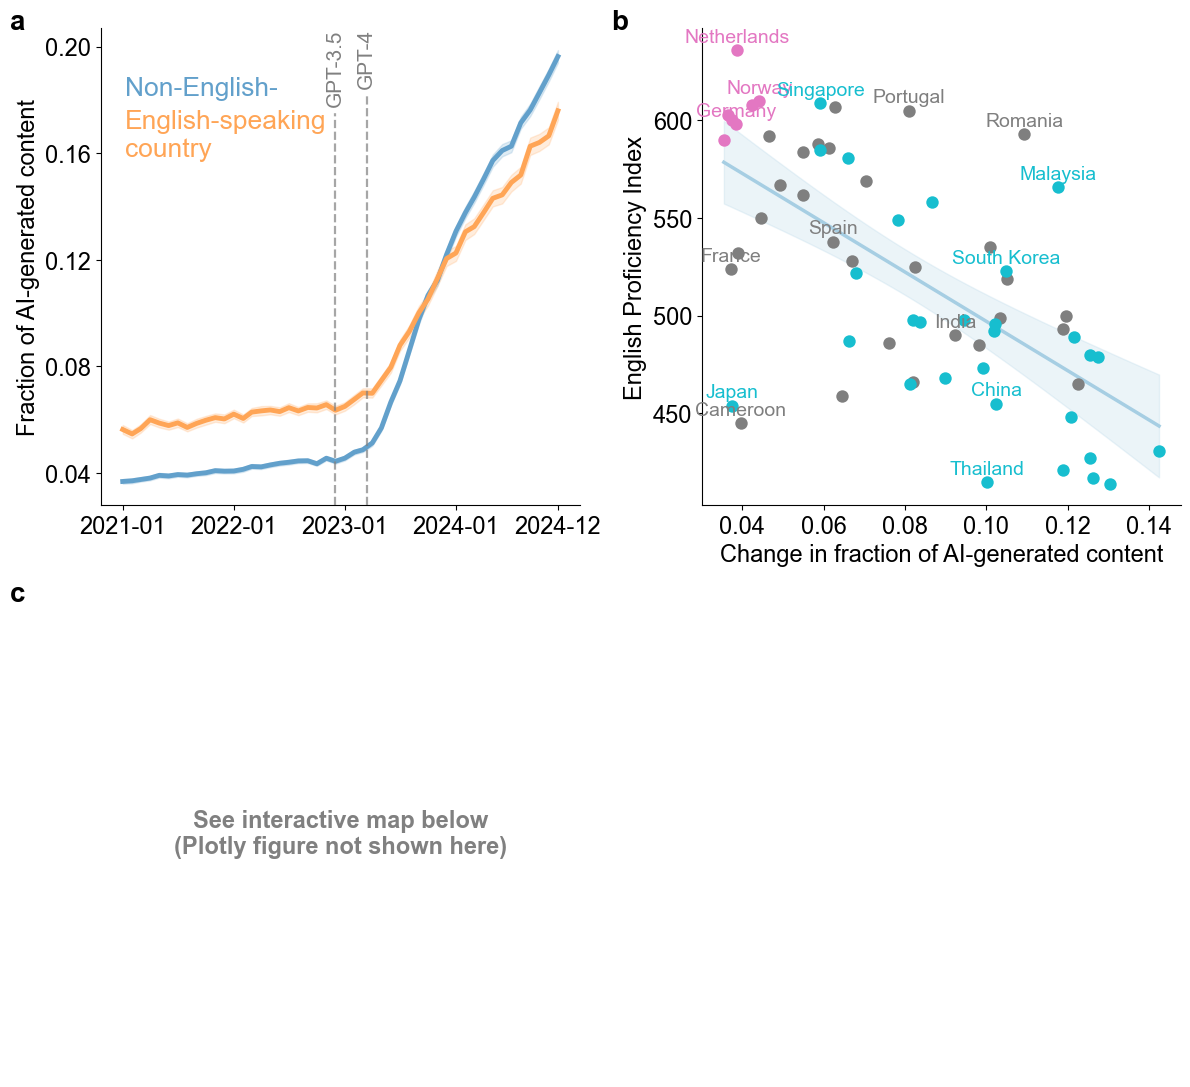

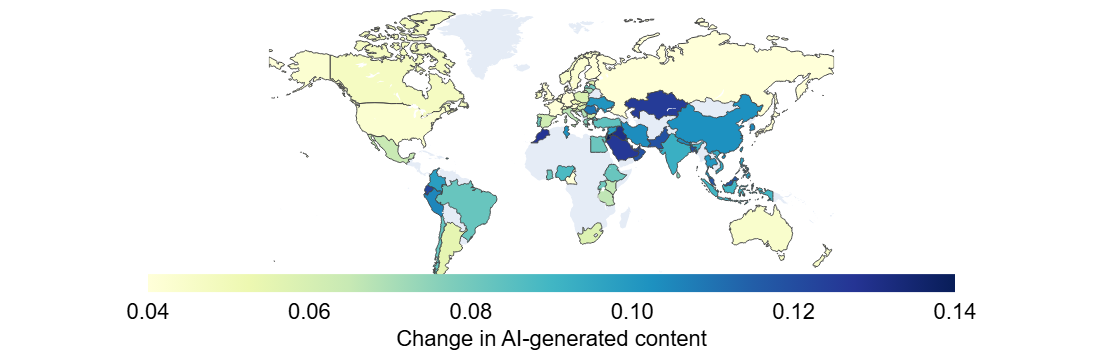

In [12]:
# Figure S2: Corresponding Author Analysis
# Define color constants (same as Figure 1)
COLOR_ENGLISH = "#62a0cb"
COLOR_NON_ENGLISH = "#ffa556"
COLOR_SCATTER_GERMANIC = "#e377c2"
COLOR_SCATTER_INDOEU = "#7f7f7f"
COLOR_SCATTER_NON_INDOEU = "#17becf"
SCATTER_TYPE_COLOR_MAP = {
    "Germanic (excl. English)": COLOR_SCATTER_GERMANIC,
    "Other Indo-European": COLOR_SCATTER_INDOEU,
    "Non Indo-European": COLOR_SCATTER_NON_INDOEU
}
COLOR_SCATTER_REG_LINE = '#a6cee3'
COLOR_SCATTER_REG_BAND = '#a6cee3'
COLOR_SCATTER_REG_BAND_ALPHA = 0.22

COLOR_MAP_CONTINUOUS = 'YlGnBu'
COLOR_LABEL_TEXT = 'black'
COLOR_MAP_PLACEHOLDER = 'gray'

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

fig, axes = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={'height_ratios': [1, 1]})

# Line plot (panel a)
ax1 = axes[0, 0]
custom_line_colors = [COLOR_ENGLISH, COLOR_NON_ENGLISH]
sns.lineplot(
    data=df,
    x='accepted_date',
    y='AI_content_fraction',
    hue='corresponding_author_english_speaking_country',
    palette=custom_line_colors,
    ax=ax1,
    linewidth=3.5,
    alpha=1
)
lines = ax1.get_lines()
label_map = {
    '1.0': "English-speaking\ncountry",
    '0.0': "Non-English-\nspeaking country"
}
hue_order = sorted(df['corresponding_author_english_speaking_country'].dropna().unique())
x0, x1 = ax1.get_xlim()
y0, y1 = ax1.get_ylim()
text_x = x0 + (x1 - x0) * 0.05
text_y = y1 - (y1 - y0) * 0.1
line_gap = (y1 - y0) * 0.07
legend_fontsize = 17
for i, val in enumerate(hue_order):
    color = custom_line_colors[i] if i < len(custom_line_colors) else lines[i].get_color()
    label = label_map.get(str(val), str(val))
    ax1.text(
        text_x,
        text_y - i * line_gap,
        label,
        color=color,
        fontsize=legend_fontsize + 2,
        fontname='Arial',
        ha='left', va='top',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=1)
    )

ax1.set_ylabel('Fraction of AI-generated content', fontname='Arial', fontsize=legend_fontsize)
date_range = pd.to_datetime(['2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01', '2024-12-01'])
ax1.set_xticks(date_range)
ax1.set_xticklabels([d.strftime('%Y-%m') for d in date_range], fontname='Arial', fontsize=legend_fontsize)
ax1.set_xlabel(None)
ax1.tick_params(axis='both', labelsize=legend_fontsize, colors=COLOR_LABEL_TEXT)
if ax1.legend_ is not None:
    ax1.legend_.remove()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
yticks_custom = [0.04, 0.08, 0.12, 0.16, 0.20]
ax1.set_yticks(yticks_custom)
ax1.set_yticklabels([f"{y:.2f}" for y in yticks_custom], fontname='Arial', fontsize=legend_fontsize)
ax1.text(-0.19, 1.04, 'a', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# Add vertical lines and annotations for GPT releases
gpt35_date = pd.to_datetime('2022-11-30')
gpt4_date = pd.to_datetime('2023-03-14')
for date, label in zip([gpt35_date, gpt4_date], ['GPT-3.5', 'GPT-4']):
    ax1.axvline(date, color='gray', linestyle='--', linewidth=1.6, alpha=0.7, zorder=5)
    ax1.text(
        date, ax1.get_ylim()[1],
        label,
        color='gray',
        fontsize=legend_fontsize - 2,
        fontname='Arial',
        rotation=90,
        va='top',
        ha='center',
        backgroundcolor='white',
        zorder=6,
        clip_on=False
    )

# Scatter plot with regression (panel b)
type_order = [
    "Germanic (excl. English)",
    "Other Indo-European",
    "Non Indo-European"
]
color_map = SCATTER_TYPE_COLOR_MAP

ax3 = axes[0, 1]
for t in type_order:
    data = country_increase_epi[country_increase_epi['language_family'] == t]
    ax3.scatter(
        data['corresponding_change'], data['score'],
        color=color_map[t],
        s=80,
        alpha=1,
        linewidth=0,
        zorder=3,
        label=t
    )

scatter_df = country_increase_epi.dropna(subset=['corresponding_change', 'score'])
X = scatter_df['corresponding_change'].values
y = scatter_df['score'].values

# Fit OLS regression
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

x_range = np.linspace(X.min(), X.max(), 200)
X_pred = sm.add_constant(x_range)
y_pred = model.predict(X_pred)
pred = model.get_prediction(X_pred)
conf_int = pred.conf_int(alpha=0.05)
ci_lower = conf_int[:, 0]
ci_upper = conf_int[:, 1]

ax3.plot(x_range, y_pred, color=COLOR_SCATTER_REG_LINE, linewidth=2.5, zorder=2)
ax3.fill_between(x_range, ci_lower, ci_upper, color=COLOR_SCATTER_REG_BAND, alpha=COLOR_SCATTER_REG_BAND_ALPHA, zorder=1)

ax3.set_xlabel('Change in fraction of AI-generated content', fontdict={'family': 'Arial', 'size': 17, 'color': COLOR_LABEL_TEXT})
ax3.set_ylabel('English Proficiency Index', fontdict={'family': 'Arial', 'size': 17, 'color': COLOR_LABEL_TEXT})
ax3.tick_params(axis='both', labelsize=legend_fontsize, colors=COLOR_LABEL_TEXT)

xticks_custom = [0.04, 0.06, 0.08, 0.10, 0.12, 0.14]
ax3.set_xticks(xticks_custom)
ax3.set_xticklabels([f"{x:.2f}" for x in xticks_custom], fontname='Arial', fontsize=legend_fontsize)
ax3.spines['bottom'].set_color(COLOR_LABEL_TEXT)
ax3.spines['left'].set_color(COLOR_LABEL_TEXT)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.text(-0.19, 1.04, 'b', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# Annotate selected countries on scatter plot
country_code_to_name_map = {
    'SG': 'Singapore', 'CN': 'China', 'NL': 'Netherlands', 'IN': 'India',
    'FR': 'France', 'DE': 'Germany', 'JP': 'Japan', 'CM': 'Cameroon',
    'RO': 'Romania', 'KR': 'South Korea', 'PT': 'Portugal', 'ES': 'Spain',
    'NO': 'Norway', 'TH': 'Thailand', 'DZ': 'Algeria', 'MY': 'Malaysia'
}
special_countries = list(country_code_to_name_map.keys())
for idx, row in country_increase_epi[country_increase_epi['country'].isin(special_countries)].iterrows():
    country_type = row['language_family']
    this_color = color_map.get(country_type, COLOR_LABEL_TEXT)
    country_label = country_code_to_name_map.get(row['country'], row['country'])
    ax3.text(
        row['corresponding_change'], row['score'] + 2, country_label,
        color=this_color, fontsize=legend_fontsize - 3, fontfamily='Arial',
        ha='center', va='bottom', zorder=15
    )

# Determine which column to use for ISO-3 codes
iso3_col = None
if 'country_iso3' in df_country.columns:
    iso3_col = 'country_iso3'
elif 'country' in df_country.columns and df_country['country'].apply(lambda c: isinstance(c, str) and len(c) == 3 and c.isalpha()).all():
    iso3_col = 'country'
else:
    raise ValueError("No valid ISO-3 code column found in df_country. Please ensure 'country_iso3' exists or 'country' is ISO-3.")

# Create choropleth map (panel c)
color_ticks = [0.04, 0.06, 0.08, 0.10, 0.12, 0.14]
color_min = min(color_ticks)
color_max = max(color_ticks)

fig_map = px.choropleth(
    data_frame=df_country,
    locations=iso3_col,
    locationmode='ISO-3',
    color='corresponding_change',
    color_continuous_scale=COLOR_MAP_CONTINUOUS,
    projection='miller',
    labels={'corresponding_change': 'Change in fraction of AI-generated content'},
    range_color=(color_min, color_max)
)
fig_map.update_geos(
    showframe=False,
    showcoastlines=False,
    lataxis_range=[-45, 90],
)
fig_map.update_layout(
    coloraxis_colorbar=dict(
        title=dict(
            text='Change in AI-generated content',
            side='bottom',
            font=dict(
                family='Arial',
                size=legend_fontsize + 5,
                color=COLOR_LABEL_TEXT
            )
        ),
        tickvals=color_ticks,
        ticktext=[f"{v:.2f}" for v in color_ticks],
        tickfont=dict(
            family='Arial',
            size=legend_fontsize + 5,
            color=COLOR_LABEL_TEXT
        ),
        thickness=18,
        orientation='h',
        x=0.5,
        xanchor='center',
        y=-0.19,  # Move colorbar further down
        yanchor='bottom',
        len=0.75
    ),
    margin=dict(l=0, r=0, t=0, b=0)
)

axes[1, 0].axis('off')
axes[1, 0].text(
    0.5, 0.51,
    "See interactive map below\n(Plotly figure not shown here)",
    ha='center', va='center', fontsize=legend_fontsize, fontweight='bold', color=COLOR_MAP_PLACEHOLDER, fontname='Arial',
    transform=axes[1, 0].transAxes
)
axes[1, 0].text(-0.19, 1.04, 'c', transform=axes[1, 0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

axes[1, 1].axis('off')

plt.tight_layout(h_pad=2)
plt.show()
pio.show(fig_map)

# Figure 2

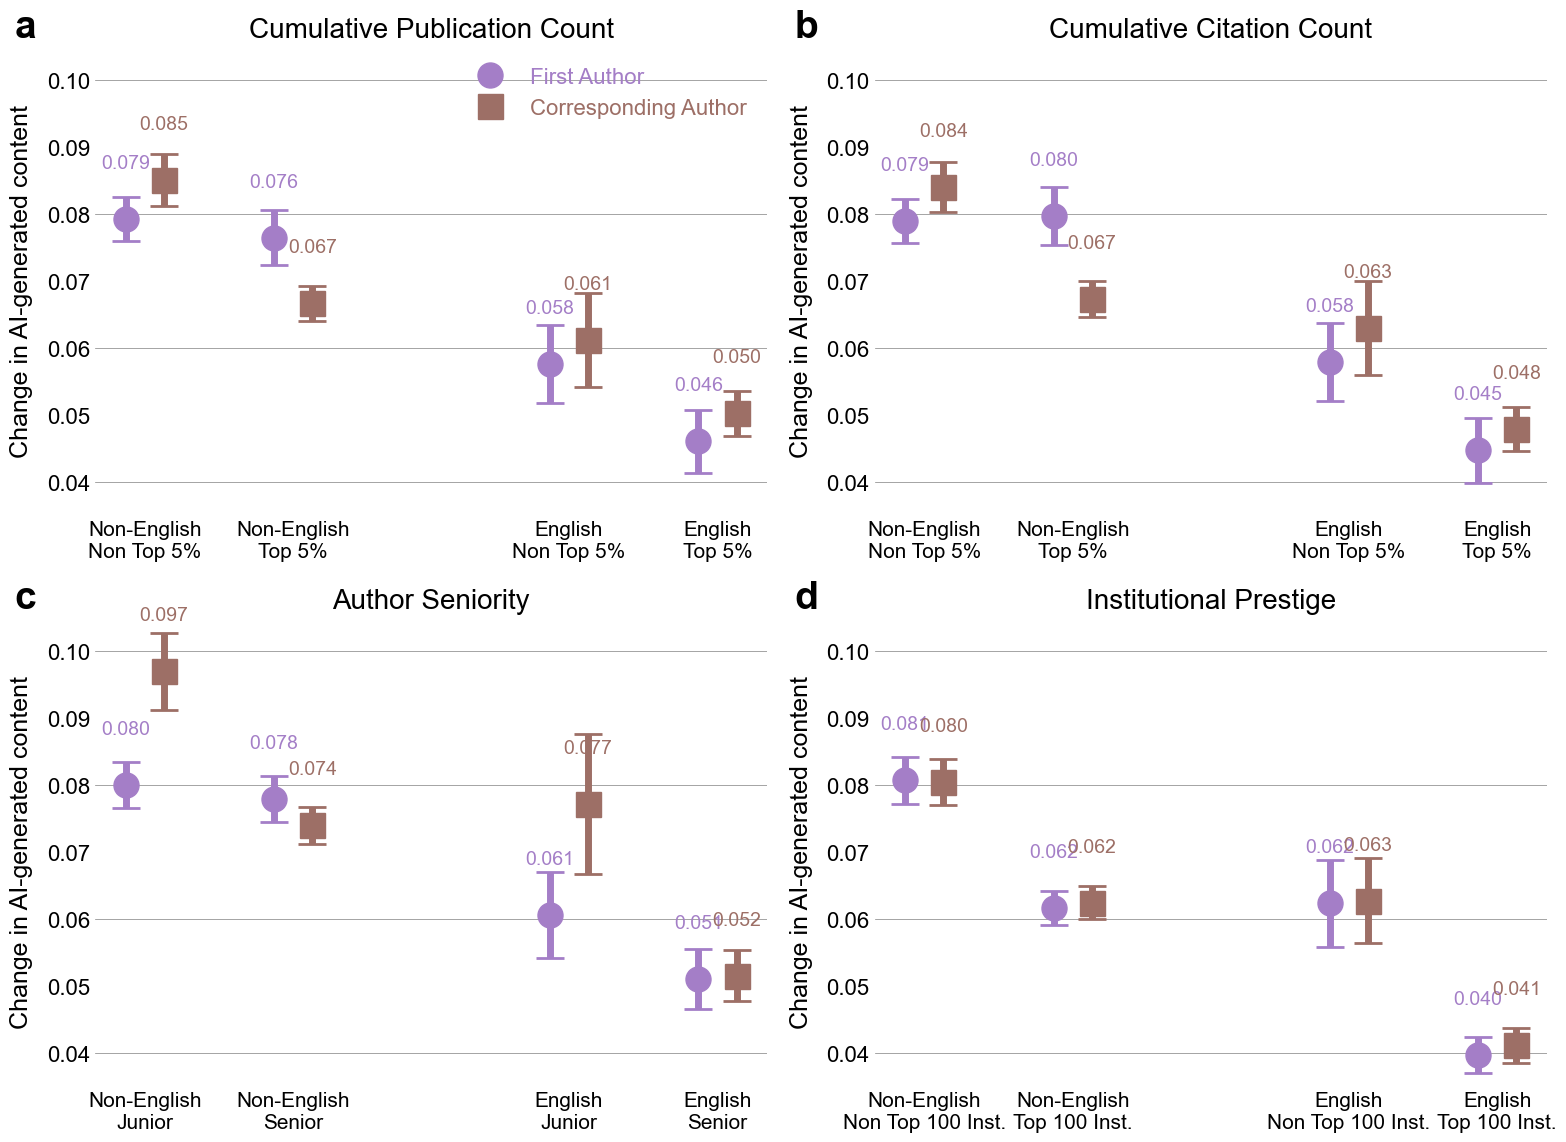

In [14]:
# Set global font style for matplotlib plots
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

# Helper function to get textual group label based on input variables
def get_group_label(english, top, indicator):
    # Assign group label depending on indicator type and value
    if indicator in ['pub', 'cit']:
        top_label = 'Top 5%' if top == 1 else 'Non Top 5%'
    elif indicator == 'age':
        top_label = 'Senior' if top == 1 else 'Junior'
    elif indicator == 'ins':
        top_label = 'Top 100 Inst.' if top == 1 else 'Non Top 100 Inst.'
    elif indicator == 'ai':
        top_label = 'AI Author' if top == 1 else 'Non AI Author'
    else:
        top_label = f'Top={top}'
    english_label = 'English' if english == 1 else 'Non-English'
    return english_label, top_label

# Mapping for main indicators to human-readable labels (panel titles)
indicator_map = {
    'pub': 'Cumulative Publication Count',
    'cit': 'Cumulative Citation Count',
    'age': 'Author Seniority',
    'ins': 'Institutional Prestige'
}

# Definitions for line/marker style and label for author order in plots
order_color = {'first': "#a47ec7", 'corresponding': "#9d6f66"}
order_marker = {'first': 'o', 'corresponding': 's'}
order_label = {'first': 'First Author', 'corresponding': 'Corresponding Author'}

# Read the data for figure 2
df = pd.read_csv('data_figure2.csv')

# Main indicators and panel setup
indicators = ['pub', 'cit', 'age', 'ins']
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12))
axes = axes.flatten()  # Flatten axes for easier iteration
panel_labels = ['a', 'b', 'c', 'd']

# Custom x-axis positions for each group in bar chart
x_pos_custom = [0, 0.7, 2, 2.7]

# Loop through indicators (subplot for each panel)
for idx, indicator in enumerate(indicators):
    ax = axes[idx]
    # Subset data for current indicator
    sub = df[df['indicator'] == indicator].copy()
    # Add formatted group label columns to the DataFrame using helper
    sub[['english_label', 'top_label']] = sub.apply(
        lambda x: pd.Series(get_group_label(x['english_speaking_country'], x['author_profile_group'], indicator)), axis=1)
    # Combine english and top label into a tuple for group assignment
    sub['group'] = list(zip(sub['english_label'], sub['top_label']))

    # Define group order for x-axis; group membership depends on indicator type
    if indicator in ['pub', 'cit']:
        group_order = [
            ('Non-English', 'Non Top 5%'),
            ('Non-English', 'Top 5%'),
            ('English', 'Non Top 5%'),
            ('English', 'Top 5%')
        ]
    elif indicator == 'age':
        group_order = [
            ('Non-English', 'Junior'),
            ('Non-English', 'Senior'),
            ('English', 'Junior'),
            ('English', 'Senior')
        ]
    elif indicator == 'ins':
        group_order = [
            ('Non-English', 'Non Top 100 Inst.'),
            ('Non-English', 'Top 100 Inst.'),
            ('English', 'Non Top 100 Inst.'),
            ('English', 'Top 100 Inst.')
        ]
    else:
        group_order = sorted(list(sub['author_profile_group'].unique()))
    # Prepare x-tick labels for current panel
    xticklabels = [f"{en}\n{top}" for en, top in group_order]
    x_pos = np.array(x_pos_custom)
    width = 0.18  # horizontal separation between first/corresponding

    # Draw plot for both first and corresponding author status
    for j, order in enumerate(['first', 'corresponding']):
        data = sub[sub['author_order'] == order]
        # set group as index, reindex so plotting groups have fixed order
        data = data.set_index('group').reindex(group_order)
        # Extract effect size and confidence intervals
        coef = data['ai_use_change'].values
        lower = data['lower'].values
        upper = data['upper'].values
        # Compute asymmetric error bars
        err = [coef - lower, upper - coef]
        # X positions for each category, shift for first/corresponding
        x = x_pos + (j-0.5)*width
        ax.errorbar(
            x, coef, yerr=err, fmt=order_marker[order],
            color=order_color[order], capsize=10, linewidth=5, capthick=2, markersize=18
        )
        # Write effect value above point
        for i, c in enumerate(coef):
            ax.text(
                x[i], c+0.007, f'{c:.3f}', va='bottom',
                ha='center', fontsize=14, color=order_color[order]
            )

    # Set x-ticks and labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xticklabels, fontsize=16, rotation=0, ha='center')
    # Set y axis label for effect
    ax.set_ylabel('Change in AI-generated content', fontsize=18, labelpad=10)
    # Panel subplot labeling (a, b, c, d)
    ax.text(
        -0.12, 1.08, panel_labels[idx], transform=ax.transAxes,
        fontsize=28, fontweight='bold', va='top', ha='left'
    )
    # Draw horizontal grid lines for reference
    for y in np.arange(0, 0.11, 0.02):
        ax.axhline(y, color='gray', linestyle='-', linewidth=0.5, zorder=0)
    # Set consistent y-axis range
    ax.set_ylim(0.035, 0.105)
    # Hide all plot frame spines for cleaner look
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)
    # Hide axis ticks
    ax.tick_params(axis='x', labelsize=15, width=0, length=0)
    ax.tick_params(axis='y', labelsize=16, width=0, length=0)

# Remove any empty/unneeded subplots
if len(axes) > len(indicators):
    for k in range(len(indicators), len(axes)):
        fig.delaxes(axes[k])

# Add readable titles for each subplot using indicator_map
for idx, indicator in enumerate(indicators):
    axes[idx].set_title(indicator_map.get(indicator, indicator), fontsize=20, pad=7, loc='center')

# Construct custom legend handles to visually distinguish author order
legend_handles = [
    Line2D([0], [0], marker=order_marker['first'], color='w', markerfacecolor=order_color['first'],
           markeredgecolor=order_color['first'], markersize=18, linewidth=0, label=order_label['first']),
    Line2D([0], [0], marker=order_marker['corresponding'], color='w', markerfacecolor=order_color['corresponding'],
           markeredgecolor=order_color['corresponding'], markersize=18, linewidth=0, label=order_label['corresponding']),
]

legend_labels = [order_label['first'], order_label['corresponding']]
legend_text_colors = [order_color['first'], order_color['corresponding']]

# Place legend on the first axes and customize label color
leg = axes[0].legend(
    handles=legend_handles,
    labels=legend_labels,
    fontsize=16,
    loc='upper right',
    frameon=False,
    handlelength=2,
    handler_map=None
)

# Change legend text to match line/marker color
for text, color in zip(leg.get_texts(), legend_text_colors):
    text.set_color(color)

# Adjust subplot layout for best appearance
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Show the full panel figure
plt.show()

# Figure S3-S5

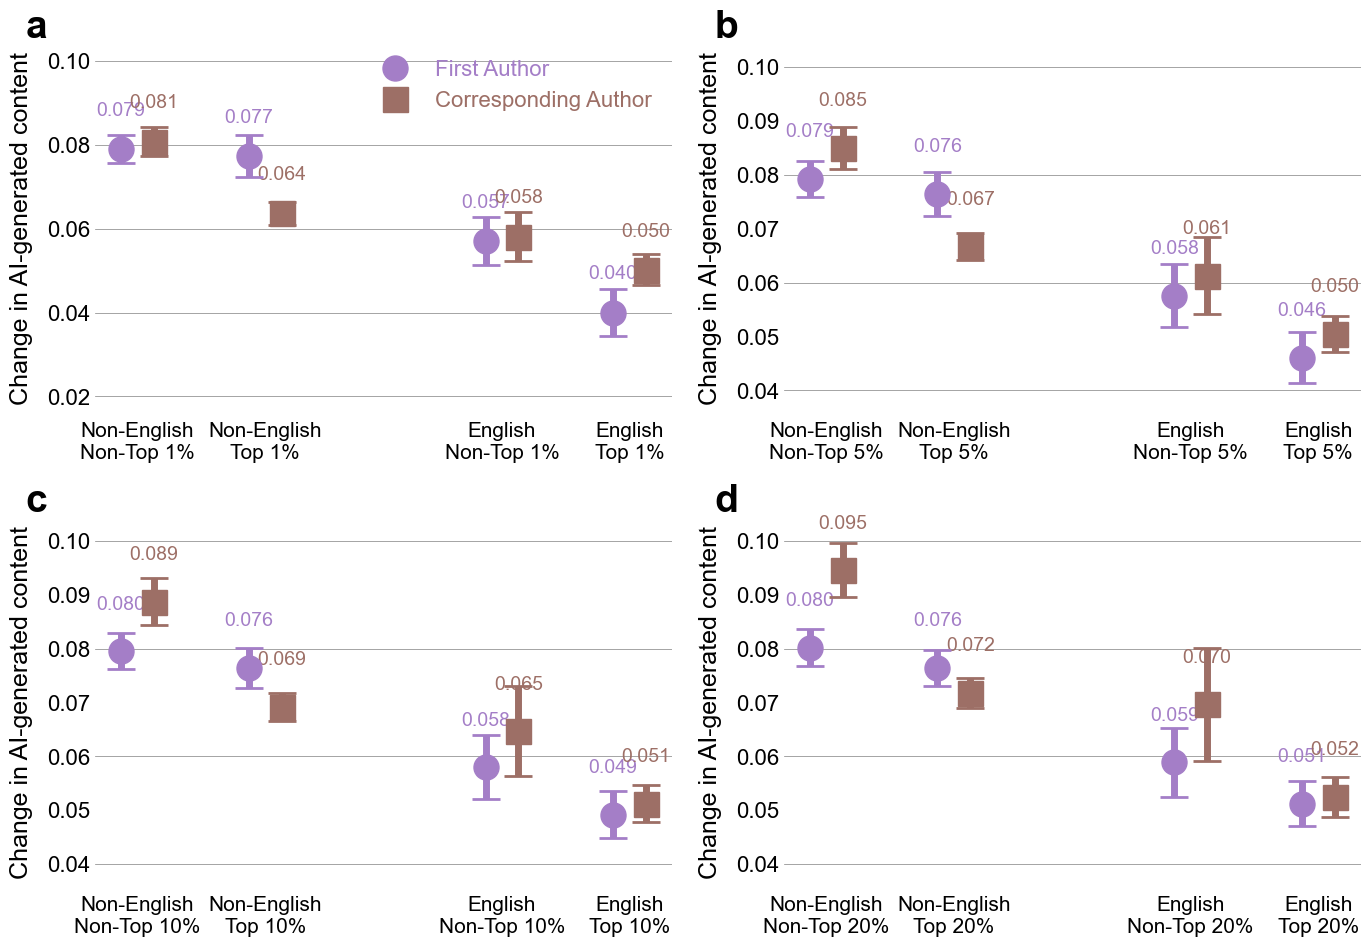

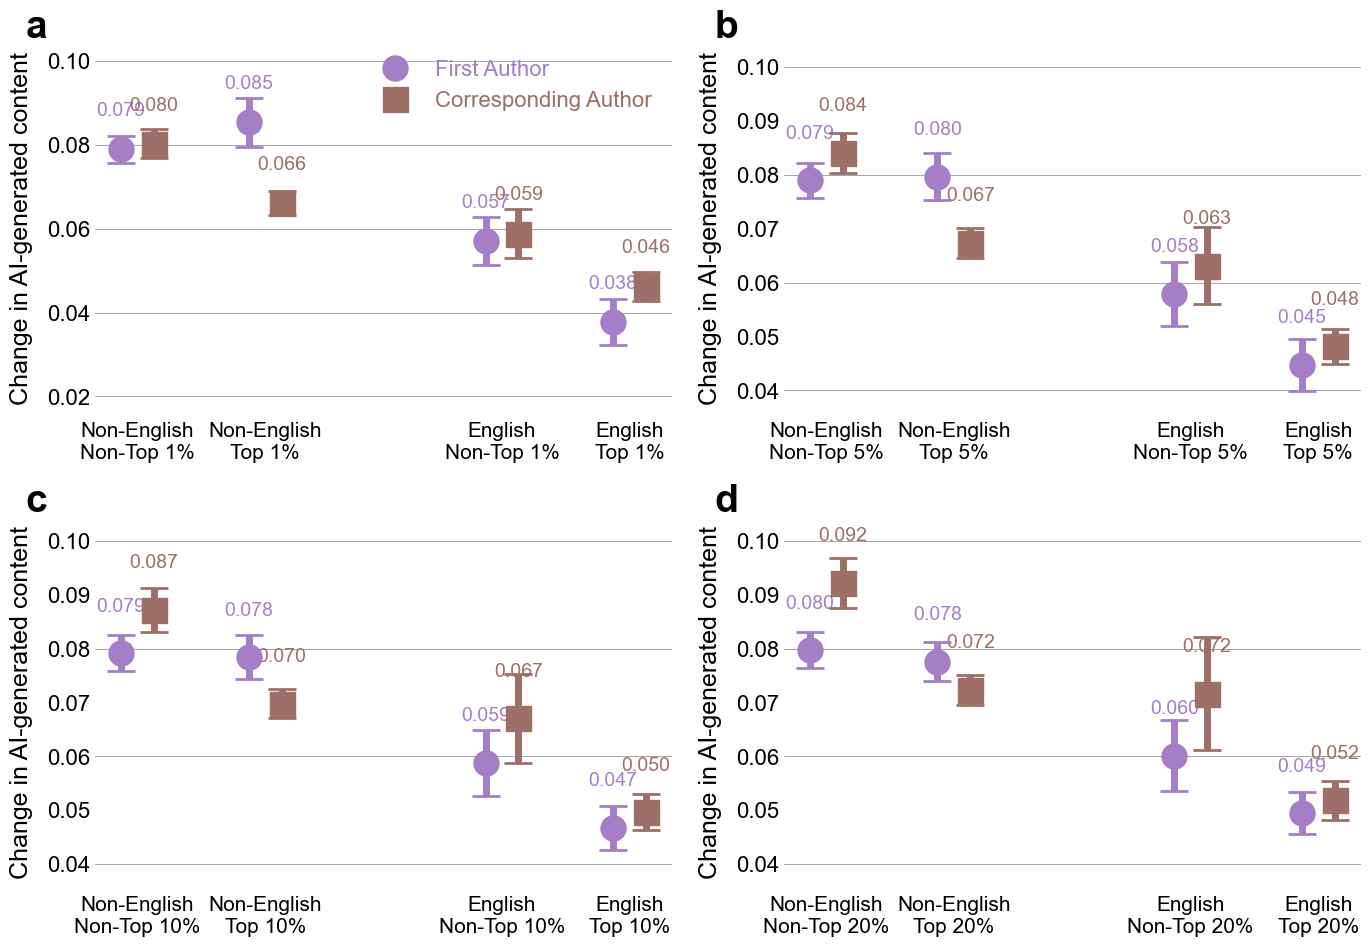

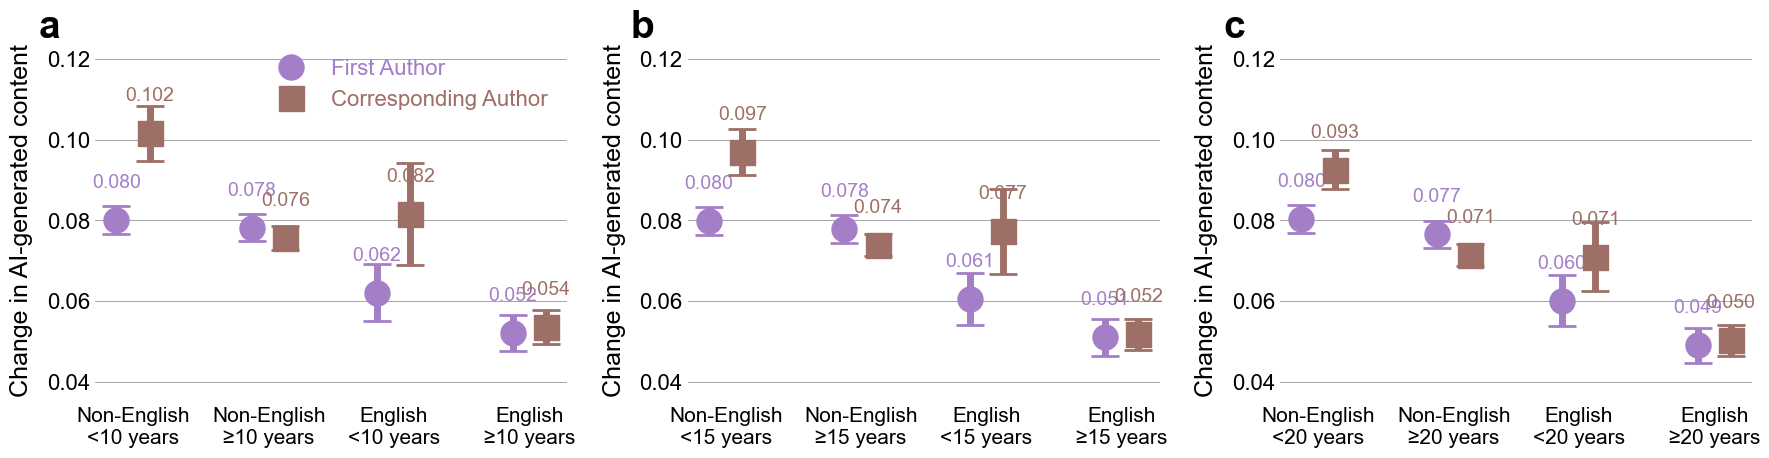

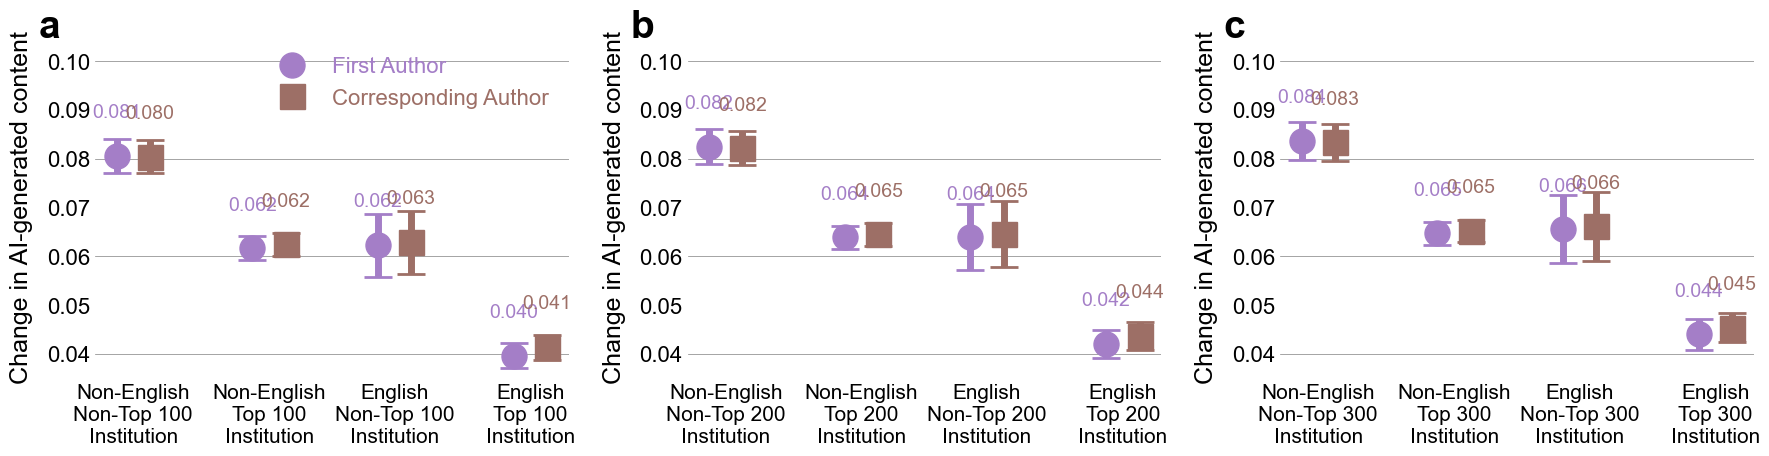

In [16]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

level_label_map = {
    'pub': {1: "Top 1%", 5: "Top 5%", 10: "Top 10%", 20: "Top 20%"},
    'cit': {1: "Top 1%", 5: "Top 5%", 10: "Top 10%", 20: "Top 20%"},
    'ins': {100: "Top 100 Inst.", 200: "Top 200 Inst.", 300: "Top 300 Inst."},
    'age': {10: "≥10 yrs Seniority", 15: "≥15 yrs Seniority", 20: "≥20 yrs Seniority"}
}

def get_group_label_level(english, top, indicator, level):
    """
    Generate group label tuples based on language, group, indicator, and level.
    """
    english_label = 'English' if english == 1 else 'Non-English'
    if indicator in ['pub', 'cit']:
        top_label = f"Top {level}%" if top == 1 else f"Non-Top {level}%"
    elif indicator == 'ins':
        top_label = f"Top {level} Inst." if top == 1 else f"Non-Top {level} Inst."
    elif indicator == 'age':
        top_label = f"≥{level} yrs Seniority" if top == 1 else f"<{level} yrs Seniority"
    else:
        top_label = f"Top={top}"
    return english_label, top_label

indicator_map = {
    'pub': 'Cumulative Publication Count',
    'cit': 'Cumulative Citation Count',
    'age': 'Author Seniority',
    'ins': 'Institution Prestige'
}

order_color = {'first': "#a47ec7", 'corresponding': "#9d6f66"}
order_marker = {'first': 'o', 'corresponding': 's'}
order_label = {'first': 'First Author', 'corresponding': 'Corresponding Author'}

df = pd.read_csv('data_figure_s3_s4_s5.csv')

indicator_for_plot = [
    ('pub', [1, 5, 10, 20]),
    ('cit', [1, 5, 10, 20]),
    ('age', [10, 15, 20]),
    ('ins', [100, 200, 300]),
]

from string import ascii_lowercase

# Control horizontal distance between first/corresponding author dots
first_corresponding_width_gap = [0.18, 0.18, 0.32, 0.32]

for idx, (indicator, level_list) in enumerate(indicator_for_plot):
    panel_labels = list(ascii_lowercase)[:len(level_list)]
    panel_label_counter = 0

    # Set panel grid and figure settings for the current indicator group
    if indicator in ['pub', 'cit']:
        nrows, ncols = 2, 2
        figsize = (14, 10)
        x_pos_custom = [0, 0.7, 2, 2.7]
    else:
        nrows, ncols = 1, 3
        figsize = (18, 5)
        x_pos_custom = [0, 1.3, 2.5, 3.8]
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=False)
    axes = np.array(axes).reshape(-1)

    for j, level in enumerate(level_list):
        ax = axes[j]
        # Filter data for the current indicator and level
        sub = df[(df['indicator'] == indicator) & (df['threshold'] == level)].copy()
        # Add language and group label columns
        sub[['english_label', 'top_label']] = sub.apply(
            lambda x: pd.Series(get_group_label_level(x['english_speaking_country'], x['author_profile_group'], indicator, level)), axis=1)
        sub['author_profile_group'] = list(zip(sub['english_label'], sub['top_label']))

        # Define group order and xtick labels by indicator type
        if indicator in ['pub', 'cit']:
            group_order = [
                ('Non-English', f"Non-Top {level}%"),
                ('Non-English', f"Top {level}%"),
                ('English', f"Non-Top {level}%"),
                ('English', f"Top {level}%")
            ]
            xticklabels = [
                f"Non-English\nNon-Top {level}%",
                f"Non-English\nTop {level}%",
                f"English\nNon-Top {level}%",
                f"English\nTop {level}%"
            ]
        elif indicator == 'age':
            group_order = [
                ('Non-English', f"<{level} yrs Seniority"),
                ('Non-English', f"≥{level} yrs Seniority"),
                ('English', f"<{level} yrs Seniority"),
                ('English', f"≥{level} yrs Seniority")
            ]
            xticklabels = [
                f"Non-English\n<{level} years",
                f"Non-English\n≥{level} years",
                f"English\n<{level} years",
                f"English\n≥{level} years"
            ]
        else:
            group_order = [
                ('Non-English', f"Non-Top {level} Inst."),
                ('Non-English', f"Top {level} Inst."),
                ('English', f"Non-Top {level} Inst."),
                ('English', f"Top {level} Inst.")
            ]
            xticklabels = [
                f"Non-English\nNon-Top {level}\nInstitution",
                f"Non-English\nTop {level}\nInstitution",
                f"English\nNon-Top {level}\nInstitution",
                f"English\nTop {level}\nInstitution"
            ]
        x_pos = np.array(x_pos_custom)
        width = first_corresponding_width_gap[idx]

        # Plot error bars for both author orders
        for k, order in enumerate(['first', 'corresponding']):
            data = sub[sub['author_order'] == order]
            data = data.set_index('author_profile_group').reindex(group_order)
            coef = data['ai_use_change'].values
            lower = data['lower'].values
            upper = data['upper'].values
            err = [coef - lower, upper - coef]
            # Apply width offset between first/corresponding
            x = x_pos + (k - 0.5) * width
            ax.errorbar(
                x, coef, yerr=err, fmt=order_marker[order],
                color=order_color[order], capsize=10, linewidth=5, capthick=2, markersize=18, zorder=5,
            )
            # Annotate each point with its numeric value
            for i, c in enumerate(coef):
                if pd.isnull(c):
                    continue
                ax.text(
                    x[i], c + 0.007, f'{c:.3f}', va='bottom',
                    ha='center', fontsize=14, color=order_color[order]
                )

        ax.set_xticks(x_pos)
        ax.set_xticklabels(xticklabels, fontsize=16, rotation=0, ha='center')
        ax.set_ylabel('Change in AI-generated content', fontsize=18, labelpad=10)

        # Add horizontal grid lines and adjust y-limits for all panels. Add additional lines for selected panels.
        for y in np.arange(0.04, 0.11, 0.02):
            ax.axhline(y, color='gray', linestyle='-', linewidth=0.5, zorder=0)
        ax.set_ylim(0.035, 0.105)

        # For subplot (a) of the first and second indicators, add an extra reference line at y = 0.02 and a lower ylim
        if (idx == 0 and j == 0) or (idx == 1 and j == 0):
            ax.set_ylim(0.015, 0.105)
            ax.axhline(0.02, color='gray', linestyle='-', linewidth=0.5, zorder=0)
        # For the third indicator ('age'), increase upper y-limit and add a line at y = 0.12
        if idx == 2:
            ax.set_ylim(0.035, 0.125)
            ax.axhline(0.12, color='gray', linestyle='-', linewidth=0.5, zorder=0)

        # Hide all axis spines and ticks
        for spine in ['top', 'right', 'left', 'bottom']:
            ax.spines[spine].set_visible(False)
        ax.tick_params(axis='x', labelsize=15, width=0, length=0)
        ax.tick_params(axis='y', labelsize=16, width=0, length=0)

        # Add panel label in bold in panel corner
        ax.text(
            -0.12, 1.08, panel_labels[panel_label_counter], transform=ax.transAxes,
            fontsize=28, fontweight='bold', va='top', ha='left'
        )
        panel_label_counter += 1

    # Remove any unused axes in grid for panels with fewer subplots
    for k in range(len(level_list), nrows * ncols):
        fig.delaxes(axes[k])

    # Draw legend for first/corresponding author
    legend_handles = [
        Line2D([0], [0], marker=order_marker['first'], color='w', markerfacecolor=order_color['first'],
               markeredgecolor=order_color['first'], markersize=18, linewidth=0, label=order_label['first']),
        Line2D([0], [0], marker=order_marker['corresponding'], color='w', markerfacecolor=order_color['corresponding'],
               markeredgecolor=order_color['corresponding'], markersize=18, linewidth=0, label=order_label['corresponding']),
    ]
    legend_labels = [order_label['first'], order_label['corresponding']]
    legend_text_colors = [order_color['first'], order_color['corresponding']]

    leg = axes[0].legend(
        handles=legend_handles,
        labels=legend_labels,
        fontsize=16,
        loc='upper right',
        frameon=False,
        handlelength=2,
        handler_map=None
    )
    # Color legend text to match marker color
    for text, color in zip(leg.get_texts(), legend_text_colors):
        text.set_color(color)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Figure 3

In [18]:
first_author_data = pd.read_csv('first_author_data.csv')
corresponding_author_data = pd.read_csv('corresponding_author_data.csv')

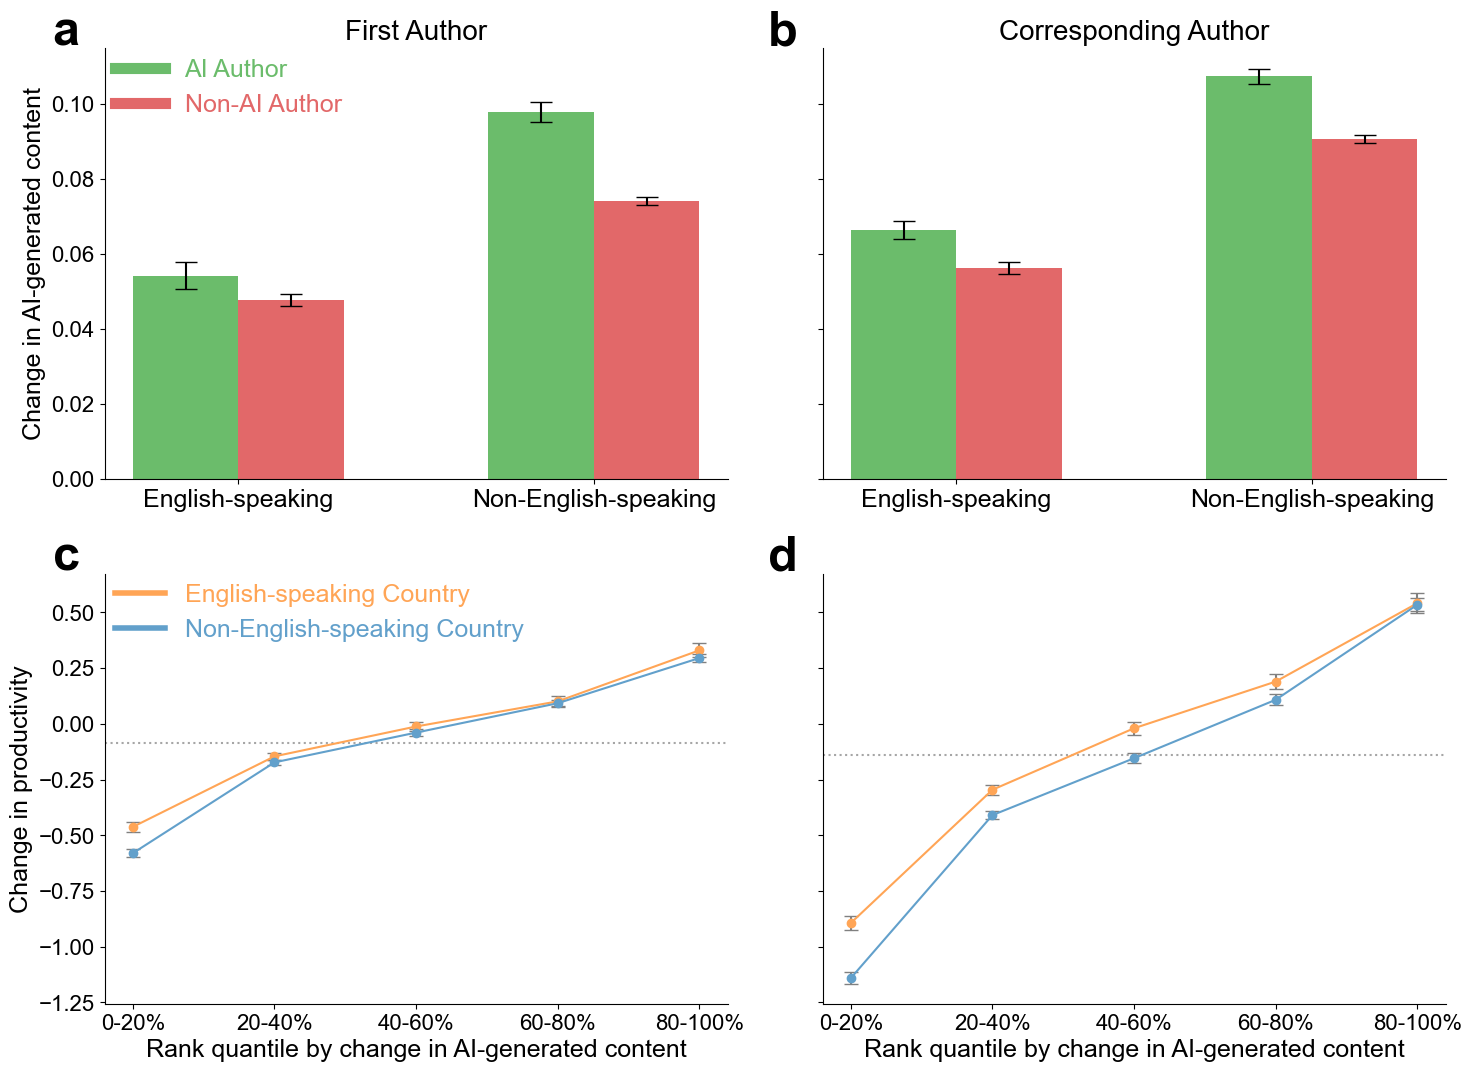

In [19]:
COLOR_AI_LIGHT = "#6bbc6b"
COLOR_NONAI_LIGHT = "#e26869"
COLOR_ENGLISH_QUANT_LIGHT = "#ffa556"
COLOR_NONENGLISH_QUANT_LIGHT = "#62a0cb"
COLOR_ENGLISH_Q_DISTR = "#ffa556"
COLOR_NONENGLISH_Q_DISTR = "#62a0cb"
COLOR_ERRORBAR = 'gray'
BAR_ALPHA = 1

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

def mean_ci(series, conf=0.95):
    arr = series.dropna().values
    n = len(arr)
    mean = np.mean(arr)
    if n > 1:
        se = stats.sem(arr)
        h = se * stats.t.ppf((1 + conf) / 2., n-1)
    else:
        h = np.nan
    return mean, h

x_labels = ['English-speaking', 'Non-English-speaking']
ai_labels = ['AI Author', 'Non-AI Author']
ai_values = [1, 0]
bar_width = 0.35
group_gap = 0.18

def get_means_cis(data, value_col, group_col, group_values, sub_group_col, sub_group_values):
    means = []
    cis = []
    for eng in group_values:
        for sub in sub_group_values:
            subset = data[
                (data[group_col] == eng) &
                (data[sub_group_col] == sub)
            ][value_col]
            m, c = mean_ci(subset)
            means.append(m)
            cis.append(c)
    return means, cis

means_first, cis_first = get_means_cis(
    first_author_data, 'ai_use_change', 'author_english_country', [1, 0], 'author_ai', ai_values)
means_last, cis_last = get_means_cis(
    corresponding_author_data, 'ai_use_change', 'author_english_country', [1, 0], 'author_ai', ai_values)


quantile_labels = [f'{i*20}-{(i+1)*20}%' for i in range(5)]

def get_results(df):
    df = df.copy()
    quantile_counts = pd.qcut(df['ai_use_change'], 5, labels=False, duplicates='drop').value_counts().sort_index()
    quantile_bins = pd.qcut(df['ai_use_change'], 5, retbins=True, duplicates='drop')[1]
    df['ai_use_change_quantile'] = pd.qcut(df['ai_use_change'], 5, labels=False, duplicates='drop')
    results = {}
    
    for group_val, label, color in zip([1, 0], ['English-speaking Country', 'Non-English-speaking Country'], [COLOR_ENGLISH_Q_DISTR, COLOR_NONENGLISH_Q_DISTR]):
        df_group = df[df['author_english_country'] == group_val]
        grouped = df_group.groupby('ai_use_change_quantile')['productivity_change']
        means = grouped.mean()
        counts = grouped.count()
        stds = grouped.std()
        conf_ints = 1.96 * stds / np.sqrt(counts)
        results[group_val] = {
            'means': means,
            'conf_ints': conf_ints,
            'label': label,
            'color': color
        }
    return results

def get_zero_quantile_and_mean(df):
    df = df.copy()
    df['ai_use_change_quantile'] = pd.qcut(df['ai_use_change'], 5, labels=False, duplicates='drop')
    zero_mask = df['ai_use_change'] == 0
    if zero_mask.sum() == 0:
        idx = (df['ai_use_change'] - 0).abs().idxmin()
        zero_quantile = df.loc[idx, 'ai_use_change_quantile']
        mean_paper_increase = df.loc[idx, 'productivity_change']
    else:
        zero_quantile = df.loc[zero_mask, 'ai_use_change_quantile'].mode().iloc[0]
        mean_paper_increase = df.loc[zero_mask, 'productivity_change'].mean()
    return int(zero_quantile), mean_paper_increase

results_first = get_results(first_author_data)
results_last = get_results(corresponding_author_data)
zero_quantile_first, mean_zero_first = get_zero_quantile_and_mean(first_author_data)
zero_quantile_last, mean_zero_last = get_zero_quantile_and_mean(corresponding_author_data)

fig, axes = plt.subplots(2, 2, figsize=(15, 11), sharey='row')

panel_labels = ['a', 'b', 'c', 'd']
for idx, (ax, means, cis, title) in enumerate(zip(
    axes[0],
    [means_first, means_last],
    [cis_first, cis_last],
    ['First Author', 'Corresponding Author']
)):
    for i in range(4):
        color = COLOR_AI_LIGHT if i % 2 == 0 else COLOR_NONAI_LIGHT
        label = ai_labels[i % 2] if i < 2 else None
        ax.bar(
            np.array([0, 0 + bar_width, 1 + group_gap, 1 + group_gap + bar_width])[i],
            means[i], width=bar_width, yerr=cis[i], capsize=8,
            color=color, alpha=BAR_ALPHA, label=label
        )
    ax.set_xticks([0 + bar_width/2, 1 + group_gap + bar_width/2])
    ax.set_xticklabels(x_labels, fontname='Arial', fontsize=18)
    ax.set_title(title, fontname='Arial', fontsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if idx == 0:
        ax.set_ylabel('Change in AI-generated content', fontname='Arial', fontsize=18)
        handles = [
            plt.Line2D([0], [0], color=COLOR_AI_LIGHT, lw=8, label='AI Author'),
            plt.Line2D([0], [0], color=COLOR_NONAI_LIGHT, lw=8, label='Non-AI Author')
        ]
        leg = ax.legend(handles=handles, loc='upper left', frameon=False, bbox_to_anchor=(0, 1), borderaxespad=0, fontsize=18)
        
        legend_texts = leg.get_texts()
        for txt, c in zip(legend_texts, [COLOR_AI_LIGHT, COLOR_NONAI_LIGHT]):
            txt.set_color(c)
            txt.set_alpha(1) 
    else:
        ax.legend().remove()
    ax.text(-0.04, 1.09, panel_labels[idx], transform=ax.transAxes, fontsize=35, fontweight='bold',
            va='top', ha='right')

for idx, (ax, results, mean_zero) in enumerate(zip(
    axes[1],
    [results_first, results_last],
    [mean_zero_first, mean_zero_last]
)):
    for group_val in [1, 0]:
        res = results[group_val]
        ax.errorbar(
            res['means'].index, res['means'].values, yerr=res['conf_ints'], fmt='o-', capsize=5,
            color=res['color'], ecolor=COLOR_ERRORBAR, label=res['label'], alpha=1
        )
    
    ax.axhline(mean_zero, color='grey', linestyle=':', alpha=0.7)
    ax.set_xlabel('Rank quantile by change in AI-generated content', fontname='Arial', fontsize=18)
    ax.set_xticks(results[1]['means'].index)
    ax.set_xticklabels([quantile_labels[i] for i in results[1]['means'].index], fontname='Arial', fontsize=16)
    
    if idx == 0:
        ax.set_ylabel('Change in productivity', fontname='Arial', fontsize=18)
        handles = [
            plt.Line2D([0], [0], color=results[1]['color'], lw=4, label=results[1]['label']),
            plt.Line2D([0], [0], color=results[0]['color'], lw=4, label=results[0]['label'])
        ]
        leg = ax.legend(handles=handles, loc='upper left', frameon=False, bbox_to_anchor=(0, 1), borderaxespad=0, fontsize=18)
        
        legend_texts = leg.get_texts()
        for txt, c in zip(legend_texts, [results[1]['color'], results[0]['color']]):
            txt.set_color(c)
            txt.set_alpha(1) 
    else:
        ax.legend().remove()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.text(-0.04, 1.09, panel_labels[idx+2], transform=ax.transAxes, fontsize=35, fontweight='bold',
            va='top', ha='right')

plt.subplots_adjust(left=0.08, right=0.98, top=0.94, bottom=0.08, wspace=0.18, hspace=0.22)
plt.tight_layout()
plt.show()

# Figure S1

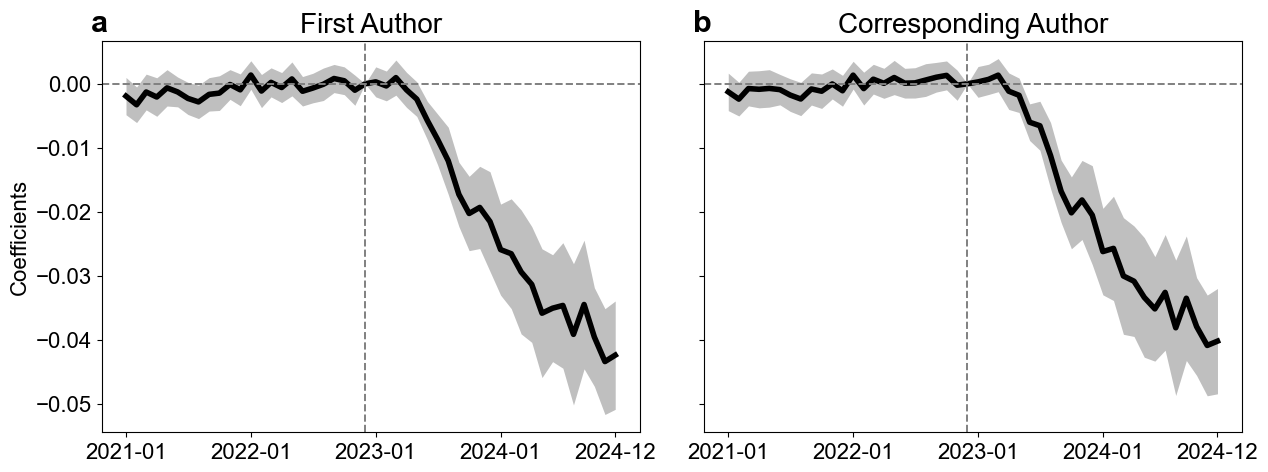

In [21]:
# Define global parameters
FONT_FAMILY = 'arial'
FONT_SIZE = 16
TITLE_SIZE = 20
LABEL_SIZE = 16
TICK_SIZE = 16
PANEL_LABEL_SIZE = 22
PANEL_LABEL_WEIGHT = 'bold'

MAIN_COLOR = 'black'
ALPHA_FILL = 0.25
LINEWIDTH_MAIN = 4
LINEWIDTH_AUX = 1.4

plt.rcParams['font.family'] = FONT_FAMILY
plt.rcParams['font.size'] = FONT_SIZE

# Load data
df = pd.read_csv('data_figure_s1.csv')

# Ensure date is string type
df['date'] = df['date'].astype(str)

# Insert 2022-12 with zero values (insert after 2022-01)
row_to_insert = {
    'date': '2022-12',
    'coef_first': 0,
    'low_first': 0,
    'high_first': 0,
    'coef_corresponding': 0,
    'low_corresponding': 0,
    'high_corresponding': 0
}
insert_idx = df[df['date'] == '2022-01'].index.max() + 1
df = pd.concat([
    df.iloc[:insert_idx],
    pd.DataFrame([row_to_insert]),
    df.iloc[insert_idx:]
], ignore_index=True)

# Sort by date to ensure correct x-axis order
df['date_dt'] = pd.to_datetime(df['date'], format='%Y-%m')
df = df.sort_values('date_dt').reset_index(drop=True)

# Target x-axis tick labels (excluding 2022-12)
target_labels = ['2021-01', '2022-01', '2023-01', '2024-01', '2024-12']

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

x = df['date_dt']

# First Author (panel a)
axes[0].plot(x, df['coef_first'], color=MAIN_COLOR, linewidth=LINEWIDTH_MAIN)
axes[0].fill_between(
    x, df['low_first'], df['high_first'],
    color=MAIN_COLOR, alpha=ALPHA_FILL, linewidth=0
)
axes[0].axhline(0, color='grey', linestyle='--', linewidth=LINEWIDTH_AUX)
# Add vertical dashed line at 2022-12 (consistent with horizontal dashed line style)
x_2022_12 = pd.to_datetime('2022-12', format='%Y-%m')
axes[0].axvline(x_2022_12, color='grey', linestyle='--', linewidth=LINEWIDTH_AUX)
axes[0].set_title('First Author', fontname=FONT_FAMILY, fontsize=TITLE_SIZE)
axes[0].set_ylabel('Coefficients', fontname=FONT_FAMILY, fontsize=LABEL_SIZE)
axes[0].tick_params(axis='both', which='major', labelsize=TICK_SIZE)
axes[0].set_xlabel('')

axes[0].text(-0.02, 1.08, 'a', transform=axes[0].transAxes, 
             fontsize=PANEL_LABEL_SIZE, fontweight=PANEL_LABEL_WEIGHT, 
             va='top', ha='left')

# Corresponding Author (panel b)
axes[1].plot(x, df['coef_corresponding'], color=MAIN_COLOR, linewidth=LINEWIDTH_MAIN)
axes[1].fill_between(
    x, df['low_corresponding'], df['high_corresponding'],
    color=MAIN_COLOR, alpha=ALPHA_FILL, linewidth=0
)
axes[1].axhline(0, color='grey', linestyle='--', linewidth=LINEWIDTH_AUX)
axes[1].axvline(x_2022_12, color='grey', linestyle='--', linewidth=LINEWIDTH_AUX)
axes[1].set_title('Corresponding Author', fontname=FONT_FAMILY, fontsize=TITLE_SIZE)
axes[1].tick_params(axis='both', which='major', labelsize=TICK_SIZE)
axes[1].set_xlabel('')

axes[1].text(-0.02, 1.08, 'b', transform=axes[1].transAxes, 
             fontsize=PANEL_LABEL_SIZE, fontweight=PANEL_LABEL_WEIGHT, 
             va='top', ha='left')

# Set x-axis to show only target labels without rotation
for ax in axes:
    tick_labels = df['date'].tolist()
    ticks_to_label = [i for i, v in enumerate(tick_labels) if v in target_labels]
    # Use date_dt for x-axis
    tick_values = df.loc[ticks_to_label, 'date_dt']
    ax.set_xticks(tick_values)
    ax.set_xticklabels([tick_labels[i] for i in ticks_to_label],
                       fontname=FONT_FAMILY, fontsize=TICK_SIZE)

plt.tight_layout()
plt.show()


# Figure s7

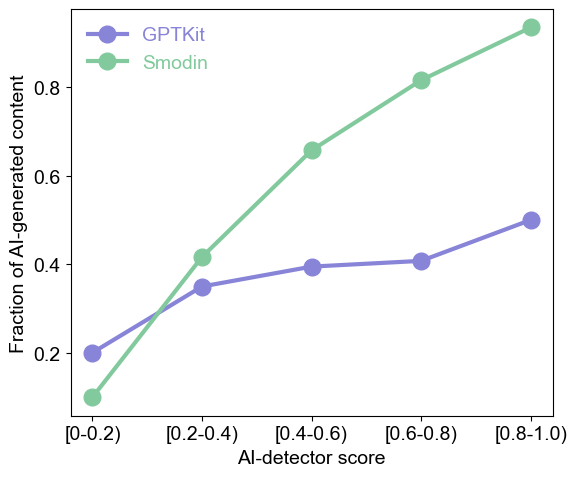

In [23]:
# Set colors and visual parameters
GPTKIT_COLOR = '#8884d8'
SMODIN_COLOR = '#82ca9d'
LINEWIDTH = 3
MARKERSIZE = 12

# Set global font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

# Read data
data1 = pd.read_csv('data_figure_s7.csv')

plt.figure(figsize=(6, 5))

# Plot GPTKit results
gptkit_line, = plt.plot(
    data1['score'], data1['GPTKit'],
    marker='o', label='GPTKit',
    color=GPTKIT_COLOR, linewidth=LINEWIDTH, markersize=MARKERSIZE
)

# Plot Smodin results
smodin_line, = plt.plot(
    data1['score'], data1['Smodin'],
    marker='o', label='Smodin',
    color=SMODIN_COLOR, linewidth=LINEWIDTH, markersize=MARKERSIZE
)

plt.xlabel('AI-detector score')
plt.ylabel('Fraction of AI-generated content')

# Legend without a frame, label color matches line color
legend = plt.legend(frameon=False)
for text, color in zip(legend.get_texts(), [GPTKIT_COLOR, SMODIN_COLOR]):
    text.set_color(color)

plt.tight_layout()
plt.show()

# Figure S8

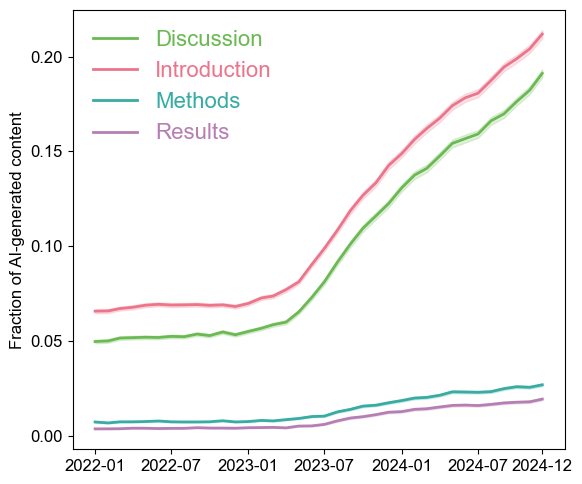

In [25]:
vis_data = pd.read_csv('data_figure_s8.csv')

# Set global font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

LINEWIDTH = 2

# Use four distinguishable section colors
SECTION_COLORS = ['#6bb952', '#ec748b', '#36aca2', '#b67fb3']

# Ensure accepted_date is datetime and extract month
vis_data['accepted_date'] = pd.to_datetime(vis_data['accepted_date'])
vis_data['month'] = vis_data['accepted_date'].dt.to_period('M').astype(str)

# Retain only records from 2022-2024 based on accepted_date
mask = (vis_data['accepted_date'] >= '2022-01-01') & (vis_data['accepted_date'] <= '2024-12-31')
filtered_data = vis_data[mask]

# Keep only necessary columns and drop rows with NA
plot_data = filtered_data[['month', 'section', 'ai_use']].dropna()

# Group by month and section; compute mean, count, and std for ai use
summary = (
    plot_data.groupby(['month', 'section'])['ai_use']
    .agg(['mean', 'count', 'std'])
    .reset_index()
)

# Calculate 95% confidence interval
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, summary['count'] - 1)

sections = summary['section'].unique()

# Mapping for legend display names
section_legend_names = {}
for sec in sections:
    if sec == 'discussion and conclusion':
        section_legend_names[sec] = 'Discussion'
    elif sec == 'introduction':
        section_legend_names[sec] = 'Introduction'
    elif sec == 'result':
        section_legend_names[sec] = 'Results'
    elif sec == 'material and method':
        section_legend_names[sec] = 'Methods'
    else:
        section_legend_names[sec] = sec

plt.figure(figsize=(6, 5))
lines = []
custom_labels = []
for idx, sec in enumerate(sections):
    color = SECTION_COLORS[idx % len(SECTION_COLORS)]
    # Sort by month for correct plotting
    data_sec = summary[summary['section'] == sec].copy()
    data_sec.sort_values('month', inplace=True)
    x = pd.to_datetime(data_sec['month'])
    y = data_sec['mean']
    ci95 = data_sec['ci95']
    # Plot line for section mean
    line, = plt.plot(
        x, y,
        label=section_legend_names[sec], linewidth=LINEWIDTH, color=color
    )
    lines.append(line)
    custom_labels.append(section_legend_names[sec])
    # Add confidence interval shading
    plt.fill_between(
        x, y - ci95, y + ci95,
        color=color, alpha=0.2
    )

plt.ylabel('Fraction of AI-generated content', fontname='Arial', fontsize=12)
# Legend without frame, match text color to line, increase font size
legend = plt.legend(frameon=False, fontsize=16)
for text, line in zip(legend.get_texts(), lines):
    text.set_color(line.get_color())

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set specific x-ticks for months of interest
xtick_labels = ['2022-01', '2022-07', '2023-01', '2023-07', '2024-01', '2024-07', '2024-12']
xtick_locs = pd.to_datetime(xtick_labels)
plt.xticks(xtick_locs, xtick_labels, fontname='Arial', fontsize=12)

plt.tight_layout()
plt.show()
